In [1]:
"""
This notebook plots the positions of all motif calls (profile union quantity) relative to the TSS.
"""

'\nThis notebook plots the positions of all motif calls (profile union quantity) relative to the TSS.\n'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm

from matplotlib.colors import LinearSegmentedColormap

: 

In [59]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

# Extract window coordinates & observed PRO-cap tracks from tfmodisco_results.tar.gz
URL = "https://zenodo.org/records/10597358/files"
TAR = "tfmodisco_results.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -xvzf {SCRATCH}/{TAR} -C {SCRATCH}")

# Download quantity motif calls
print(f"wget {URL}/profile_annotated_seqlets_full_cleaned.bed.gz -P {SCRATCH}")
print(f"wget {URL}/quantity_annotated_seqlets_full_cleaned.bed.gz -P {SCRATCH}")

wget https://zenodo.org/records/10597358/files/tfmodisco_results.tar.gz -P /Users/adamhe/github/scratch
tar -xvzf /Users/adamhe/github/scratch/tfmodisco_results.tar.gz -C /Users/adamhe/github/scratch
wget https://zenodo.org/records/10597358/files/profile_annotated_seqlets_full_cleaned.bed.gz -P /Users/adamhe/github/scratch
wget https://zenodo.org/records/10597358/files/quantity_annotated_seqlets_full_cleaned.bed.gz -P /Users/adamhe/github/scratch


In [4]:
def epdf(coords, start=-200, end=200):
    a = np.zeros(end - start)
    for coord in tqdm.tqdm(coords):
        if coord in range(start, end):
            a[coord - start] += 1
    return pd.DataFrame(a, index=range(start, end))

In [60]:
# LOAD DATA

# Read in windows around PRO-cap peaks in LCLs
all_bed = pd.read_csv(
    Path(SCRATCH, "tfmodisco_results/merged_windows_all.bed.gz"),
    sep="\t",
    header=None,
    names=["chrom", "start", "end"],
)
# Load the experimental data:
signals = pd.read_csv(
    Path(SCRATCH, "tfmodisco_results/all_tss_windows_procap_mean.csv.gz"),
    header=None,
    index_col=0,
).to_numpy()
signals = signals[:, np.r_[250:750, 1250:1750]]

In [61]:
# Load the motif calls
profile_motifs = pd.read_csv(
    Path(SCRATCH, "profile_annotated_seqlets.bed.gz"),
    sep="\t",
    header=None,
    names=["chrom", "start", "end", "peak_idx", "motif"]
)

# Print motif counts
profile_motifs["motif_prefix"] = profile_motifs.motif.str.split("-").str[0]
print(profile_motifs.motif_prefix.value_counts())

# Load the motif calls
quantity_motifs = pd.read_csv(
    Path(SCRATCH, "quantity_annotated_seqlets.bed.gz"),
    sep="\t",
    header=None,
    names=["chrom", "start", "end", "peak_idx", "motif"]
)

# Print motif counts
quantity_motifs["motif_prefix"] = quantity_motifs.motif.str.split("-").str[0]
print(quantity_motifs.motif_prefix.value_counts())

profile_motifs_ = profile_motifs[["chrom", "start", "end", "peak_idx", "motif_prefix"]]
quantity_motifs_ = quantity_motifs[["chrom", "start", "end", "peak_idx", "motif_prefix"]]
all_motifs = pd.concat([profile_motifs_, quantity_motifs_]).drop_duplicates()

motif_prefix
CA        95428
TBP       74654
ETS       59373
DPR       48096
YY1       32166
SP/KLF    31933
IRF       29433
TA        23545
NFY       19756
NRF1      19323
Name: count, dtype: int64
motif_prefix
ETS       178061
SP/KLF    148873
NRF1       54866
IRF        37179
CA         29290
CTCF       20255
CREB       20224
NFY        17793
YY1        15891
TFEC        9279
TBP         8854
THAP        8725
ZBTB33      7738
POU         3811
ZNF76       2696
NFKB2       2039
Name: count, dtype: int64


In [62]:
# Get TSS coordinates
tss = signals.argmax(axis=1)
is_mn = tss >= 500
tss_df = pd.DataFrame(
    {
        "tss": tss,
        "is_mn": is_mn,
    }
)
# Subtract 500 from tss if is_mn
tss_df["tss"] = tss_df["tss"].apply(lambda x: x - 500 if x >= 500 else x) + 250

In [63]:
motif_positions = []
for i, hit in tqdm.tqdm(all_motifs.iterrows()):
    peak_idx = hit["peak_idx"]
    tss_coord = tss_df["tss"].iloc[peak_idx] + all_bed.iloc[peak_idx]["start"]
    motif_center = (hit["end"] + hit["start"]) // 2
    tss_strand = tss_df["is_mn"].iloc[peak_idx]
    motif_positions.append(
        tss_coord - motif_center if tss_strand else motif_center - tss_coord
    )

all_motifs["distance_from_tss"] = motif_positions

760084it [00:32, 23210.65it/s]


In [65]:
xticks = [-200, -100, -50, 0, 50, 100, 200]

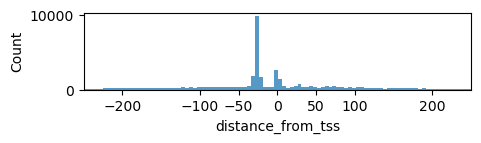

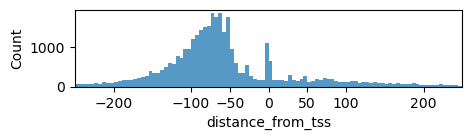

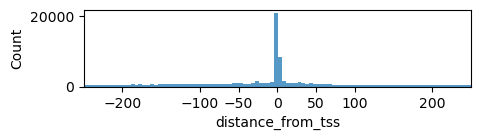

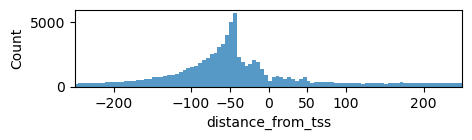

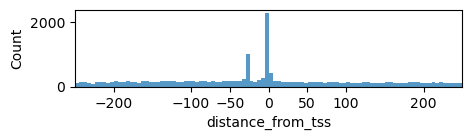

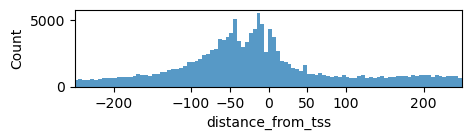

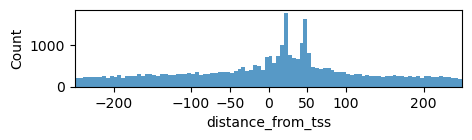

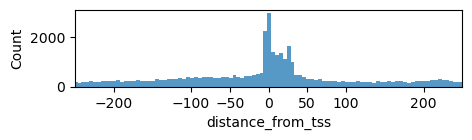

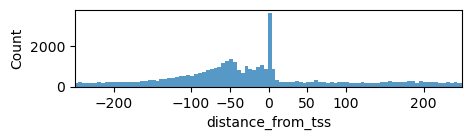

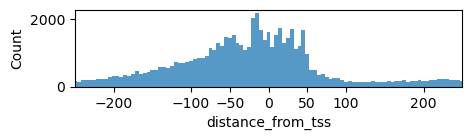

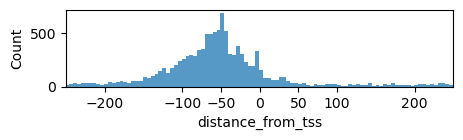

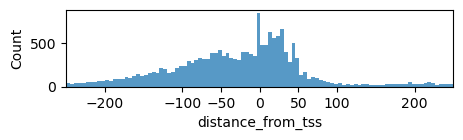

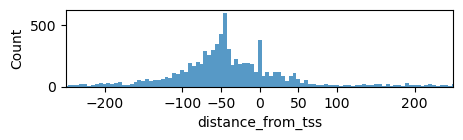

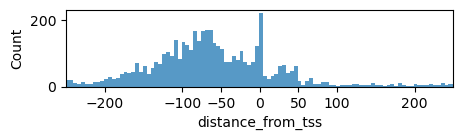

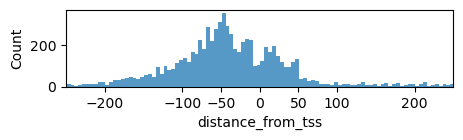

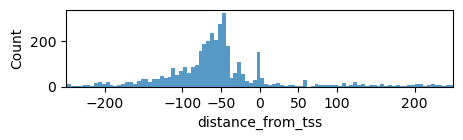

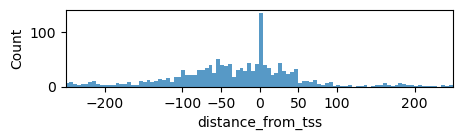

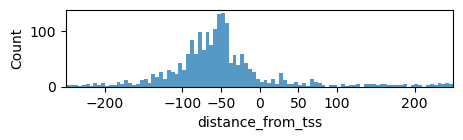

In [26]:
# Generate all motif positioning plots
for motif_name in all_motifs.motif_prefix.unique():
    # Get motif positions
    motif_positions = all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"]
    # Set image parameters
    plt.rcParams["figure.figsize"] = 5,1
    fig, (ax) = plt.subplots(nrows = 1, sharex = True)
    # Plot
    #sns.kdeplot(motif_positions, bw_adjust=0.5)
    sns.histplot(motif_positions, binwidth=5, edgecolor='None')
    ax.set_xlim(-250, 250)
    ax.set_xticks(xticks)
    plt.savefig(
        f"img/{motif_name.replace("/", "")}_hist.pdf",
        bbox_inches="tight",
    )

100%|██████████| 114202/114202 [00:00<00:00, 121969.88it/s]


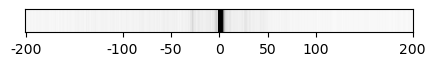

In [48]:
motif_name = "CA"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)
dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Greys", aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
#ax.set_xlim(-250, 250)
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

  0%|          | 0/43981 [00:00<?, ?it/s]

100%|██████████| 43981/43981 [00:00<00:00, 84115.09it/s] 


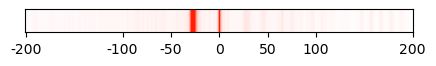

In [73]:
motif_name = "TBP"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#FF1E02"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap=custom_cmap, aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
#ax.set_xlim(-250, 250)
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 48096/48096 [00:00<00:00, 99819.61it/s] 


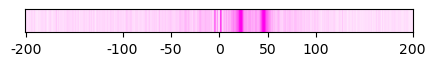

In [50]:
motif_name = "DPR"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#FF02EC"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap=custom_cmap, aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 96275/96275 [00:00<00:00, 148909.42it/s]


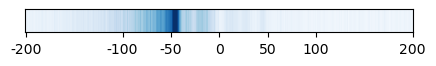

In [51]:
motif_name = "SP/KLF"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 47802/47802 [00:00<00:00, 119187.35it/s]


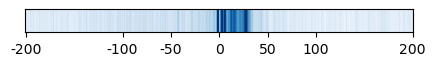

In [72]:
motif_name = "YY1"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 37547/37547 [00:00<00:00, 156949.90it/s]


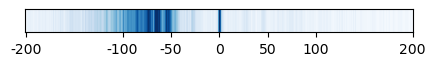

In [53]:
motif_name = "NFY"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 170576/170576 [00:01<00:00, 132273.76it/s]


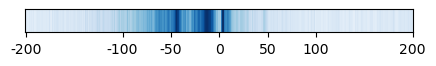

In [54]:
motif_name = "ETS"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 67638/67638 [00:00<00:00, 130474.79it/s]


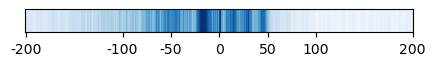

In [55]:
motif_name = "NRF1"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 52360/52360 [00:00<00:00, 136647.02it/s]


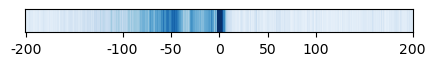

In [71]:
motif_name = "IRF"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 47802/47802 [00:00<00:00, 116680.80it/s]


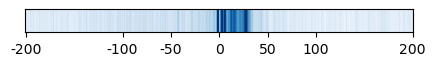

In [57]:
motif_name = "YY1"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)